https://www.youtube.com/c/HuggingFace/playlists

In [1]:
# %pip install transformers

Import necessary libraries

In [52]:
import io
import os
import torch
import time
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
# from ml_things import plot_dict, plot_confusion_matrix, fix_text
from transformers import (set_seed,TrainingArguments,Trainer,AdamW,get_linear_schedule_with_warmup)
from transformers import BertTokenizer, BertModel, BertConfig

In [4]:
df_valid = pd.read_csv('./Data/IMDB/Valid.csv')
df_test = pd.read_csv('./Data/IMDB/Test.csv')

In [17]:
df_test.head()

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


A torch.device is an object representing the device on which a torch.Tensor is or will be allocated.

https://pytorch.org/docs/stable/tensor_attributes.html


In [13]:
epochs = 2
batch_size = 32
max_length = 128
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_labels = 2

Tokenizing is used to transform raw text into numbers. The three main types of tokenizers used in Transformers: Byte-Pair Encoding (BPE), WordPiece, and SentencePiece

https://huggingface.co/docs/transformers/tokenizer_summary

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [27]:
token_lens = []
for txt in df_valid.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

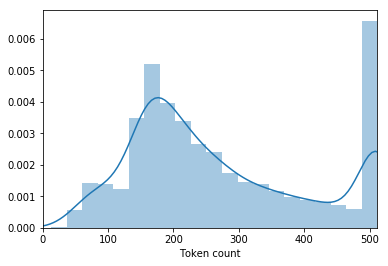

In [28]:
import seaborn as sns
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

https://pytorch.org/docs/stable/generated/torch.nn.Module.html

In [29]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased',return_dict=True,output_hidden_states=True)
        self.l2 = torch.nn.Linear(768,n_labels)
    
    def forward(self, ids, mask, token_type_ids):
        output_1= self.l1(ids, attention_mask = mask)
        output_1 = output_1.hidden_states[-1][:,0,:]
        output_2 = self.l2(output_1)
        return output_2

model = BERTClass()
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
df_valid.head()

,text,label
0,It's been about 14 years since Sharon Stone aw...,0
1,someone needed to make a car payment... this i...,0
2,The Guidelines state that a comment must conta...,0
3,This movie is a muddled mish-mash of clichés f...,0
4,Before Stan Laurel became the smaller half of ...,0


In [31]:
# sentiment_score = []
# for idx,exmp in df_sentiment.iterrows():
#   if(exmp['sentiment']==1):
#     sentiment_score.append([0,1])
#   else:
#     sentiment_score.append([1,0])

In [32]:
# df_sentiment['sentiment_score'] = sentiment_score

In [33]:
df_valid.head()

,text,label
0,It's been about 14 years since Sharon Stone aw...,0
1,someone needed to make a car payment... this i...,0
2,The Guidelines state that a comment must conta...,0
3,This movie is a muddled mish-mash of clichés f...,0
4,Before Stan Laurel became the smaller half of ...,0


https://pytorch.org/docs/stable/nn.html#loss-functions

A custom Dataset class must implement three functions: __init__, __len__, and __getitem__.

# For most of the BERT Tasks we need input_ids,token_type_ids,attention_mask

# Input_ids

Let text : "A Titan RTX has 24GB of VRAM"

After tokenization : ['A', 'Titan', 'R', '##T', '##X', 'has', '24', '##GB', 'of', 'V', '##RA', '##M']

Tokens are converted to ids : [101, 138, 18696, 155, 1942, 3190, 1144, 1572, 13745, 1104, 159, 9664, 2107, 102]

Decoding back : [CLS] A Titan RTX has 24GB of VRAM [SEP]

# Attention_mask

To tell the attention layers to ignore the padding tokens we need to pass them an attention mask . The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them.



#Token_type_ids

Some models’ purpose is to do classification on pairs of sentences or question answering.


text : [CLS] HuggingFace is based in NYC [SEP] Where is HuggingFace based? [SEP]

token_type_ids : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]

https://huggingface.co/docs/transformers/v4.16.2/en/glossary

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [34]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.label = dataframe.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            pad_to_max_length = True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'label': torch.tensor(self.label[index], dtype=torch.float),
            'text' : text
        }

In [48]:
train_dataset = CustomDataset(df_valid, tokenizer, max_length)
valid_dataset = CustomDataset(df_test, tokenizer, max_length)
train_params = {'batch_size': batch_size,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': batch_size,
                'shuffle': False,
                'num_workers': 0
                }

train_dataloader = DataLoader(train_dataset, **train_params)
valid_dataloader = DataLoader(valid_dataset, **test_params)

1.   Design model (input,output size,forward pass)
2.   Construct loss and optimizer
3.   Training loop
    *   Forward pass : compute prediction
    *   backward pass : gradients
    *   update weights















In [49]:
def loss_fn(outputs, targets):
    crossEntropy = torch.nn.CrossEntropyLoss()
    return crossEntropy(outputs, targets)

In [50]:
optimizer = torch.optim.AdamW(params =  model.parameters(), lr = 3e-5, eps = 1e-8)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 200, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [53]:
def train(epoch):
    model.train()
    t0_epoch = time.time()
    total_loss = 0
    for _,data in enumerate(train_dataloader, 0):
        
        ids = data['ids'].to(device, dtype = torch.long)
        ids = ids.squeeze()
        mask = data['mask'].to(device, dtype = torch.long)
        mask = mask.squeeze()
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['label'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask,token_type_ids)
        
        optimizer.zero_grad() #
        
        loss = loss_fn(outputs, targets)
            
        loss.backward() #
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #
        
        total_loss += loss.item()
        
        optimizer.step() #
        
        scheduler.step() #
        
    avg_train_loss = total_loss / len(train_dataloader)
    time_elapsed = time.time() - t0_epoch
    print(f"{epoch + 1:^7} | {avg_train_loss:^12.6f} | {time_elapsed:^9.2f}")

In [54]:
def validation(epoch):
    model.eval()
    final_targets=[]
    final_outputs=[]
    val_texts = []
    with torch.no_grad():
        for _, data in enumerate(valid_dataloader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            ids = ids.squeeze()
            mask = data['mask'].to(device, dtype = torch.long)
            mask = mask.squeeze()
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['label']
            texts = data['text']

            outputs = model(ids, mask,token_type_ids)
            final_targets.extend(targets.numpy().tolist())
            final_outputs.extend(outputs.cpu().detach().numpy().tolist())
            val_texts.extend(texts)
    return final_outputs, final_targets, val_texts

In [55]:
# train_df= df_sentiment.groupby('label', group_keys=False).apply(lambda x: x.sample(int(len(x)*0.8)))
# val_df= df_sentiment.drop(train_df.index).reset_index(drop=True)
# train_df = train_df.reset_index(drop=True)

# print("TRAIN Dataset: {}".format(train_df.shape))
# print("TEST Dataset: {}".format(val_df.shape))

In [56]:
# ?torch.utils.data.DataLoader

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples

In [61]:
print("Start training...\n")
print ( f"{'Epoch':^7} | {'Train_Loss':^12} | {'Elapsed':^9}") 
print("-"*35)
for epoch in range(epochs):
    train(epoch)

Start training...

 Epoch  |  Train_Loss  |  Elapsed 
-----------------------------------


/opt/anaconda/envs/env_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/anaconda/envs/env_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/anaconda/envs/env_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 0, Loss:  0.16936519742012024
   1    |   0.163270   |   77.69  
Epoch: 1, Loss:  0.14602753520011902
   2    |   0.163546   |   79.00  


In [57]:
outputs, targets, texts = validation(epoch)


/opt/anaconda/envs/env_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/anaconda/envs/env_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/anaconda/envs/env_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [58]:
import numpy as np
outputs = np.argmax(outputs, axis = 1)

In [60]:
from sklearn.metrics import classification_report
target_names = ['positive','negative']
y_true = targets
y_pred = outputs
print(classification_report(y_true, y_pred,target_names=target_names))

              precision    recall  f1-score   support

    positive       0.91      0.82      0.86      2495
    negative       0.84      0.92      0.88      2505

    accuracy                           0.87      5000
   macro avg       0.88      0.87      0.87      5000
weighted avg       0.88      0.87      0.87      5000



In [ ]:
torch.save(model.state_dict(), "model_sentiment.bin")

In [17]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained("bert-base-uncased")

In [39]:
text = "playing played plays cricket, football he is doing suprisingly well in the project hateful non-hateful neutral."
encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)

In [40]:
encoded_input.input_ids

tensor([[  101,  2652,  2209,  3248,  4533,  1010,  2374,  2002,  2003,  2725,
         10514, 18098,  9355,  2135,  2092,  1999,  1996,  2622,  5223,  3993,
          2512,  1011,  5223,  3993,  8699,  1012,   102]])

In [41]:
tokenizer.tokenize(text)

['playing',
 'played',
 'plays',
 'cricket',
 ',',
 'football',
 'he',
 'is',
 'doing',
 'su',
 '##pr',
 '##ising',
 '##ly',
 'well',
 'in',
 'the',
 'project',
 'hate',
 '##ful',
 'non',
 '-',
 'hate',
 '##ful',
 'neutral',
 '.']